##**Pre-requisites**

In [ ]:
!pip install timm
!wget https://gist.githubusercontent.com/Dhruvanshu-Joshi/de4684e117849150ecec8422ec01f0d3/raw/b04142695d695cd57b87f7f1bd93228e3820c8c7/imagenet_classes.txt -O imagenet_classes.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-03 07:19:44--  https://gist.githubusercontent.com/Dhruvanshu-Joshi/de4684e117849150ecec8422ec01f0d3/raw/b04142695d695cd57b87f7f1bd93228e3820c8c7/imagenet_classes.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31564 (31K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  30.82K  --.-KB/s    in 0.003s  

2023-04-03 07:19:45 (11.4 MB/s) - ‘imagenet_classes.txt’ saved [31564/31564]



##**Imports**

In [ ]:
from PIL import Image
import torch
import timm
import requests
import torchvision.transforms as transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import pandas as pd
import numpy as np
import os
import json

## **Model quantization**

In [ ]:
def get_size(file_path: str, unit: str ='bytes'):
    file_size = os.path.getsize(file_path)
    exponents_map = {'bytes': 0, 'kb': 1, 'mb': 2, 'gb': 3}
    if unit not in exponents_map:
        raise ValueError("Must select from \
        ['bytes', 'kb', 'mb', 'gb']")
    else:
        size = file_size / 1024 ** exponents_map[unit]
        return round(size, 3)


def get_image(URL: str):
  img = Image.open(requests.get(URL, stream=True).raw)
  img.show()
  return img


def get_model(name: str):
  model = timm.create_model(name, pretrained=True)
  return model


def get_quantized_model(model):
  backend = "x86"
  model.qconfig = torch.quantization.get_default_qconfig(backend)
  torch.backends.quantized.engine = backend

  quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)
  scripted_quantized_model = torch.jit.script(quantized_model)
  return scripted_quantized_model


def get_output(model1, model2, file_name, model1_name, model2_name):
  with torch.autograd.profiler.profile(use_cuda=False) as profile1:
    out = model1(img)
  with torch.autograd.profiler.profile(use_cuda=False) as profile2:
      out = model2(img)
    # reading the data from the file
  with open(file_name) as f:
      data = f.read()
  # reconstructing the data as a dictionary
  js = json.loads(data)

  print("original model: {:.2f}ms".format(profile1.self_cpu_time_total/1000))
  print("original model size: {:.2f}mb".format(get_size(model1_name, 'mb')))
  print("original model prediction: {0}".format(js[str(prediction_model.item())]))
  print("scripted & quantized model: {:.2f}ms".format(profile2.self_cpu_time_total/1000))
  print("scripted & quantized model size: {:.2f}mb".format(get_size(model2_name, 'mb')))
  print("scripted & quantized model prediction: {0}".format(js[str(prediction_quantized_model.item())]))

  return profile1, profile2


def get_table(profile1, profile2, model1_name, model2_name):
  df = pd.DataFrame({'Model': ['original model', 'scripted & quantized model']})
  df = pd.concat([df, pd.DataFrame([
      ["{:.2f}ms".format(profile1.self_cpu_time_total/1000), "0%", "{:.2f}mb".format(get_size(model1_name, 'mb')), "0%"],
      ["{:.2f}ms".format(profile2.self_cpu_time_total/1000),
      "{:.2f}%".format((profile1.self_cpu_time_total-profile2.self_cpu_time_total)/profile1.self_cpu_time_total*100),
      "{:.2f}mb".format(get_size(model2_name, 'mb')),
      "{:.2f}%".format((get_size(model1_name, 'mb')-get_size(model2_name, 'mb'))/(get_size(model1_name, 'mb'))*100)]],
      columns=['Inference Time', 'Time-Reduction', 'Size', 'Size-Reduction'])], axis=1)

  print(df)

In the code down below, we first get an image of a zebra using the ```get_image``` function.

Next, we create a model, ```'swin_small_patch4_window7_224'``` available in the timm library using the ```get_model``` helper function.

Moving forward, to get classification of the image that we have, we first pre-process the image to meet the input requirements of the model. 

We then proceed to quantize the model using the PyTorch built-in quantization and predict the output for the same image inorder to verify if quantization was valid.

Once the above steps are done, we report performance gain in inference time and model size reduction.

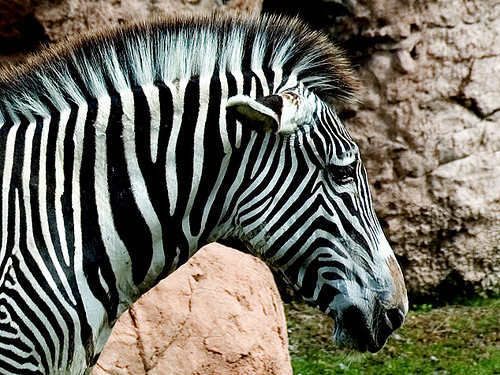

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Model prediction: 340


/usr/local/lib/python3.9/dist-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Quantized Model prediction: 340
original model: 674.77ms
original model size: 190.93mb
original model prediction: zebra
scripted & quantized model: 515.56ms
scripted & quantized model size: 49.51mb
scripted & quantized model prediction: zebra


In [ ]:
img = get_image("https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02391049_zebra.JPEG")

model = get_model('swin_small_patch4_window7_224')
scripted_model = torch.jit.script(model)
scripted_model.save("pt_swin_small.pt")
model.eval()

transform = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

img = transform(img)[None,]
out = model(img)
prediction_model = torch.argmax(out)
print("Model prediction: {0}".format(prediction_model.item()))

scripted_quantized_model = get_quantized_model(model)
scripted_quantized_model.save("pt_swin_small_quantized.pt")

out = scripted_quantized_model(img)
prediction_quantized_model= torch.argmax(out)
print("Quantized Model prediction: {0}".format(prediction_quantized_model.item()))

profile1, profile2 = get_output(model, scripted_quantized_model, "imagenet_classes.txt", "pt_swin_small.pt", "pt_swin_small_quantized.pt")

Lastly, we chart a table

In [ ]:
get_table(profile1, profile2, "pt_swin_small.pt", "pt_swin_small_quantized.pt")

                        Model Inference Time Time-Reduction      Size  \
0              original model       674.77ms             0%  190.93mb   
1  scripted & quantized model       515.56ms         23.59%   49.51mb   

  Size-Reduction  
0             0%  
1         74.07%  
